In [24]:
# Importing all required libraries
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
from math import atan2, degrees
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Reading data, and labels
df = pd.read_parquet(r'/content/ltd_2022-12-01.parquet')
df2 = pd.read_parquet(r'/content/landjob.parquet')
sample_data = list(df['asset_id'].unique())
len(sample_data)

747

In [26]:
# Selecting one particular sample for analysis

# temp_data ='f6e040b0-c458-11eb-a543-cd97eca8a696'
temp_data = sample_data[15]

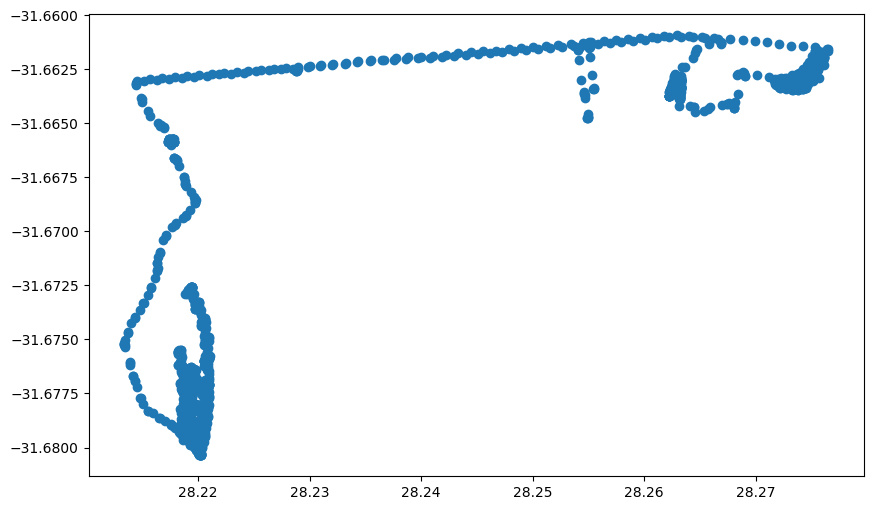

In [27]:
# DataFrame mods and scatter plot of original live tracking data

df = df[df['asset_id']==temp_data]
df = df[df['engine_state']=='ON']
figsize = (10, 6)
plt.figure(figsize=figsize)
plt.scatter(df['longitude'], df['latitude']);

In [28]:
# Reading labels from the landjob file_requires_unicode

temp_df = df2[df2['asset_id']==temp_data]
temp_df['polygon_geojson']

all_latitudes = []
all_longitudes = []

for polygon_geojson in temp_df['polygon_geojson']:
  try:
    polygon_data = json.loads(polygon_geojson)
    if polygon_data and 'coordinates' in polygon_data:
      coordinates = polygon_data['coordinates'][0]
      for lon, lat in coordinates:
          all_longitudes.append(lon)
          all_latitudes.append(lat)
  except (TypeError, KeyError, json.JSONDecodeError):
    print(f"Skipping invalid GeoJSON: {polygon_geojson}")
    continue
print(f"Number of latitudes: {len(all_latitudes)}")
print(f"Number of longitudes: {len(all_longitudes)}")

Number of latitudes: 104
Number of longitudes: 104


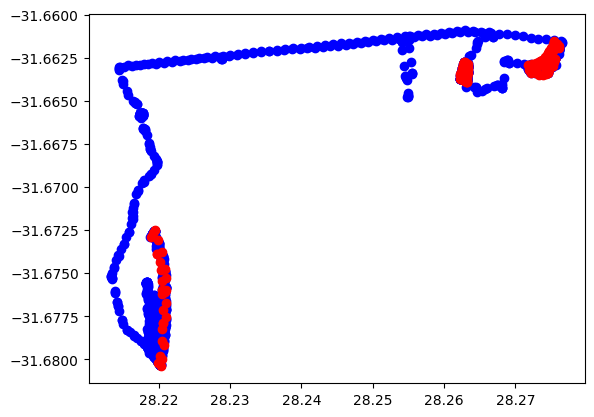

In [14]:
# Plotting original live tracking points vs the labels from Landjob.

plt.scatter(df['longitude'], df['latitude'], color='blue');
plt.scatter(all_longitudes, all_latitudes, color='red');

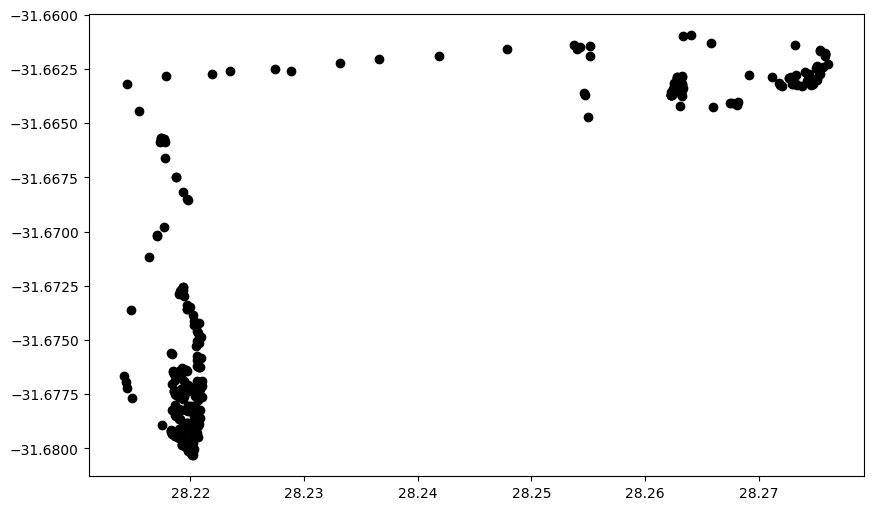

In [15]:
# Resampling the data to 2 mins, to eliminate inconsistency

df = df.set_index('time').resample('2min').last().reset_index()
plt.figure(figsize=figsize)
plt.scatter(df['longitude'], df['latitude'], color='black');

In [16]:
# Calculating angle formation between 3 points to present trajectory angle.

thresh = 180

def calculate_angle(lat1, lon1, lat2, lon2, lat3, lon3):
  lat1, lon1 = np.radians(lat1), np.radians(lon1)
  lat2, lon2 = np.radians(lat2), np.radians(lon2)
  lat3, lon3 = np.radians(lat3), np.radians(lon3)

  y1 = np.sin(lon2 - lon1) * np.cos(lat2)
  x1 = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lon2 - lon1)
  bearing1 = atan2(y1, x1)

  y2 = np.sin(lon3 - lon2) * np.cos(lat3)
  x2 = np.cos(lat2) * np.sin(lat3) - np.sin(lat2) * np.cos(lat3) * np.cos(lon3 - lon2)
  bearing2 = atan2(y2, x2)

  angle = degrees(bearing2 - bearing1)

  if angle > thresh:
      angle -= 360
  elif angle <= -thresh:
      angle += 360

  return angle

df['angle'] = np.nan
for i in range(1, len(df) - 1):
  df['angle'].iloc[i] = calculate_angle(df['latitude'].iloc[i-1], df['longitude'].iloc[i-1],
                                       df['latitude'].iloc[i], df['longitude'].iloc[i],
                                       df['latitude'].iloc[i+1], df['longitude'].iloc[i+1])



lower_threshold = 150
upper_threshold = 180

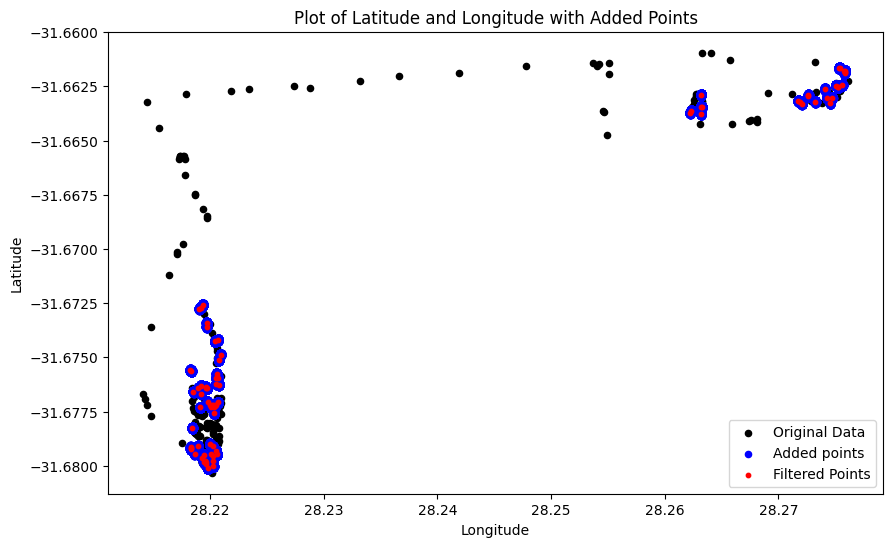

In [18]:
# Approprioate filtering to retain farming activity
filtered_df = df[((df['angle'] < -lower_threshold) & (df['angle'] > -upper_threshold)) |
                   ((df['angle'] > lower_threshold) & (df['angle'] < upper_threshold))]

# Function to generate points around a given coordinate
def generate_nearby_points(lat, lon, num_points=1000, radius_meters=10):
    lat_points = []
    lon_points = []
    for _ in range(num_points):
        # Generate random offsets within the radius
        u = np.random.uniform(0, 1)
        v = np.random.uniform(0, 1)
        w = radius_meters * np.sqrt(u)
        t = 2 * np.pi * v
        x = w * np.cos(t)
        y = w * np.sin(t)

        # Convert offsets to latitude/longitude changes
        dx = x / (111132 * np.cos(np.radians(lat)))  # Adjust for latitude's effect on longitude
        dy = y / 111132

        lat_points.append(lat + dy)
        lon_points.append(lon + dx)
    return lat_points, lon_points

# Generate and add nearby points
all_latitudes_new = []
all_longitudes_new = []

for index, row in filtered_df.iterrows():
  lat, lon = row['latitude'], row['longitude']
  lat_points, lon_points = generate_nearby_points(lat, lon)
  all_latitudes_new.extend(lat_points)
  all_longitudes_new.extend(lon_points)

# Plot all points vs farming activity
plt.figure(figsize=(10, 6))
plt.scatter(df['longitude'], df['latitude'], color='black', label='Original Data', s = 20)  # Original data points
plt.scatter(all_longitudes_new, all_latitudes_new, color='blue', label='Added points', s = 20) # New points
plt.scatter(filtered_df['longitude'], filtered_df['latitude'], color='red', label='Filtered Points', s = 10) # Filtered points

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Plot of Latitude and Longitude with Added Points")
plt.legend()
plt.show()

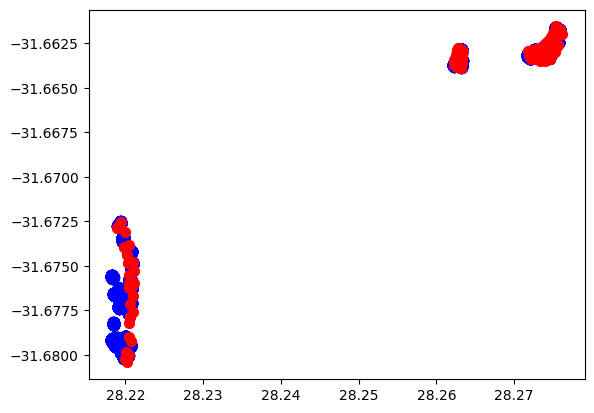

In [19]:
# Plotting farming activity vs farming labels.

plt.scatter(all_longitudes_new, all_latitudes_new, color='blue', label='Added points', s = 50);
plt.scatter(all_longitudes, all_latitudes, color='red', label='Original points', s = 50);

    latitude  longitude  cluster
0 -31.663661  28.262243        0
1 -31.663724  28.262200        0
2 -31.663673  28.262165        0
3 -31.663727  28.262201        0
4 -31.663674  28.262250        0


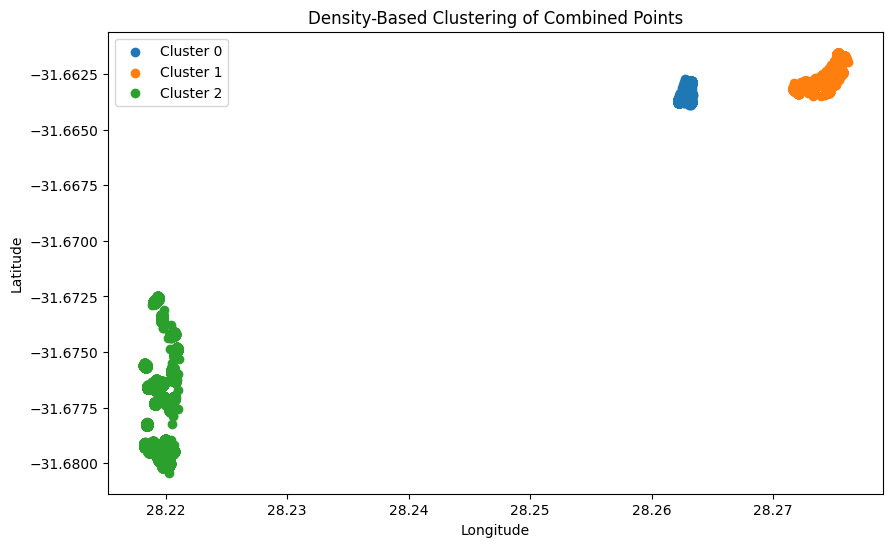

In [20]:
import pandas as pd
from sklearn.cluster import DBSCAN
import numpy as np

# Assuming 'all_latitudes_new', 'all_longitudes_new', 'all_latitudes', and 'all_longitudes' are defined from the previous code

# Combine added and filtered points
combined_data = np.column_stack((all_latitudes_new + all_latitudes, all_longitudes_new + all_longitudes))

# Apply DBSCAN
dbscan = DBSCAN(eps=0.001, min_samples=1000)
clusters = dbscan.fit_predict(combined_data)

# Create a DataFrame for the combined data and cluster labels
combined_df = pd.DataFrame({'latitude': combined_data[:, 0], 'longitude': combined_data[:, 1], 'cluster': clusters})

# Now you have the combined data with cluster labels
print(combined_df.head())

# Plot the clusters (optional)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for cluster_label in np.unique(clusters):
  cluster_data = combined_df[combined_df['cluster'] == cluster_label]
  plt.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {cluster_label}')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Density-Based Clustering of Combined Points")
plt.legend()
plt.show()


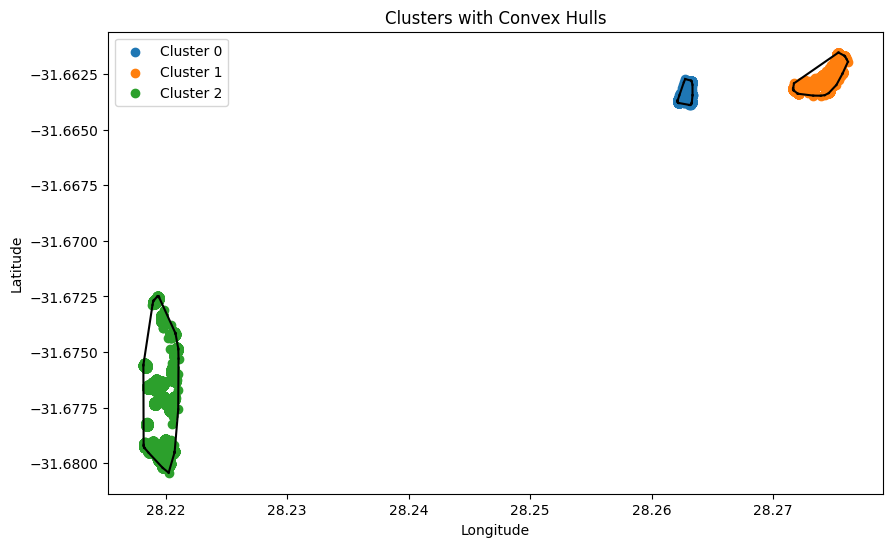

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Plot the clusters and their convex hulls
plt.figure(figsize=(10, 6))

for cluster_label in np.unique(clusters):
    if cluster_label == -1:  # Skip noise points
        continue
    cluster_data = combined_df[combined_df['cluster'] == cluster_label]

    # Calculate the convex hull
    points = cluster_data[['longitude', 'latitude']].values
    hull = ConvexHull(points)

    # Plot the cluster points
    plt.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {cluster_label}')

    # Plot the convex hull
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Clusters with Convex Hulls")
plt.legend()
plt.show()


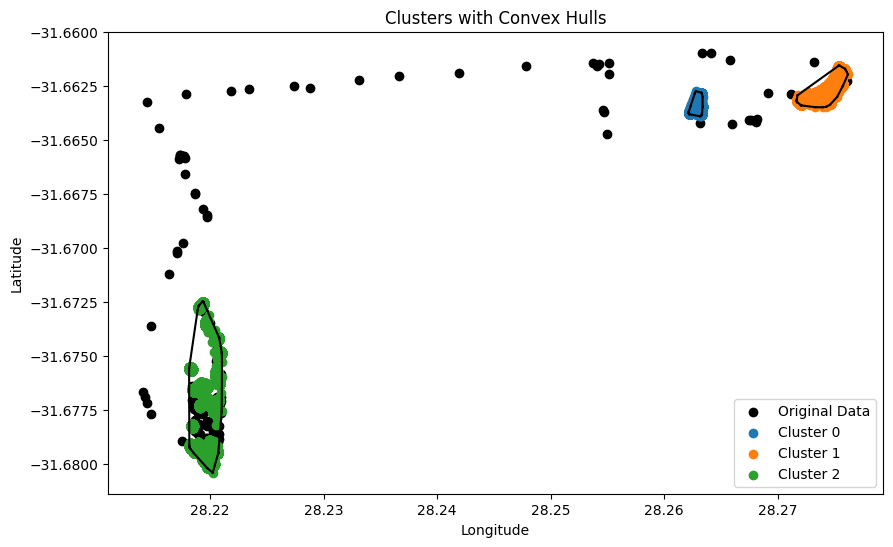

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Plot the clusters and their convex hulls
plt.figure(figsize=(10, 6))
plt.scatter(df['longitude'], df['latitude'], color='black', label='Original Data');
for cluster_label in np.unique(clusters):
    if cluster_label == -1:  # Skip noise points
        continue
    cluster_data = combined_df[combined_df['cluster'] == cluster_label]

    # Calculate the convex hull
    points = cluster_data[['longitude', 'latitude']].values
    hull = ConvexHull(points)

    # Plot the cluster points
    plt.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {cluster_label}')

    # Plot the convex hull
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Clusters with Convex Hulls")
plt.legend()
plt.show()

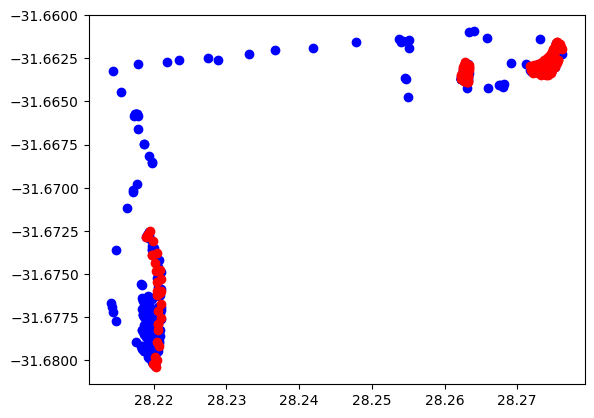

In [23]:
plt.scatter(df['longitude'], df['latitude'], color='blue');
plt.scatter(all_longitudes, all_latitudes, color='red');